In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import os

In [2]:
data = pd.read_csv("combined_data_nonconcat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.asarray(y_train.values.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.values.tolist())
y_test = y_test.reshape(-1,1)

In [9]:
print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8820, 34)
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
def displayStats(model,modelname: str,test: np.ndarray,truth: np.ndarray):
    predictions = model.predict(test) #all of them should have this
    print(modelname+" STATS:")
    print("ACCURACY: "+str(accuracy_score(truth,predictions)))

   #not all models have predict_proba
    if callable(getattr(model, "predict_proba", None)):
        soft_predictions = model.predict_proba(test)[:,1]
        print("ROC AUC: "+str(roc_auc_score(truth,soft_predictions)))
    
    cmat = confusion_matrix(truth,predictions)
    disp = ConfusionMatrixDisplay(cmat)
    disp.plot()
    plt.show()

# Catboost Classifier - Attempt 2
---
## Issues with the first attempt
---
We found that our first attempt varied (in accuracy) greatly between different random test sets. This could indicate overfitting portions of the data. This could be due to a relatively small dataset size, which leads to the classifier not being able to really learn the correct things. 

---
## Improvement ideas
---
First, we will try to see if performance goes up if we try to train a "good frame" vs "bad frame" binary classifier, instead of a "good clip" vs "bad clip" binary classifier. The idea is that this will significantly increase the size of the dataset that we have available to us, helping the classifier generalize a bit more. 

If this yields improved results, we will then try to extend this concept of "good frames" vs "bad frames" by trying to create a basic composite score for each clip based on its proportion of good frames and bad frames. We can output this both as a soft score (the exact percentage of good vs bad) and as a hard score (if more good frames, we predict good clip, if more bad frames, we predict bad clip).

---
### Frame by Frame Classifier
---

In [5]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train,y_train)

Learning rate set to 0.022413
0:	learn: 0.6888037	total: 61.1ms	remaining: 1m 1s
1:	learn: 0.6840354	total: 71.5ms	remaining: 35.7s
2:	learn: 0.6797466	total: 82ms	remaining: 27.3s
3:	learn: 0.6761008	total: 94.7ms	remaining: 23.6s
4:	learn: 0.6729370	total: 106ms	remaining: 21.1s
5:	learn: 0.6692455	total: 116ms	remaining: 19.2s
6:	learn: 0.6658914	total: 129ms	remaining: 18.3s
7:	learn: 0.6630698	total: 141ms	remaining: 17.5s
8:	learn: 0.6596530	total: 152ms	remaining: 16.7s
9:	learn: 0.6569107	total: 163ms	remaining: 16.1s
10:	learn: 0.6536753	total: 174ms	remaining: 15.6s
11:	learn: 0.6508208	total: 184ms	remaining: 15.1s
12:	learn: 0.6482675	total: 195ms	remaining: 14.8s
13:	learn: 0.6448188	total: 209ms	remaining: 14.7s
14:	learn: 0.6422034	total: 221ms	remaining: 14.5s
15:	learn: 0.6395781	total: 232ms	remaining: 14.3s
16:	learn: 0.6369842	total: 243ms	remaining: 14.1s
17:	learn: 0.6348478	total: 254ms	remaining: 13.9s
18:	learn: 0.6323225	total: 264ms	remaining: 13.6s
19:	learn

CATBOOST REV 2 STATS:
ACCURACY: 0.8877551020408163
ROC AUC: 0.9560337340586003


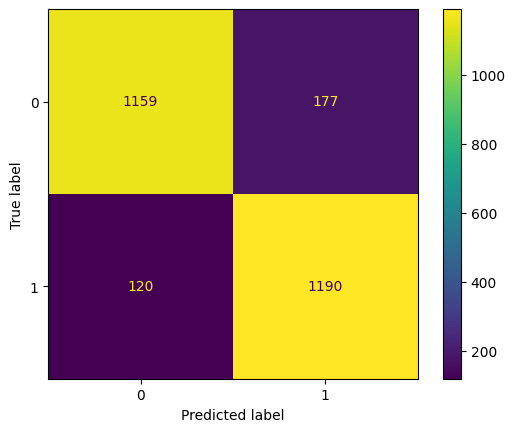

In [10]:
displayStats(cbm, "CATBOOST REV 2", X_test, y_test)

### Sanity Check

---

Let's generate a histogram of multiple CBTrees on different splits, and their respective statistics

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
accuracies = []
for i in range(100):
    data = pd.read_csv("combined_data_nonconcat.csv",header=None)
    data = data.sample(frac=1)
    data = data.reset_index(drop=True)
    labels = data[0]
    data = data.drop(0,axis='columns')
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = np.asarray(y_train.values.tolist())
    y_train = y_train.reshape(-1,1)
    y_test = np.asarray(y_test.values.tolist())
    y_test = y_test.reshape(-1,1)

    cbm = CatBoostClassifier(silent=True)
    cbm.fit(X_train,y_train)

    predictions = cbm.predict(X_test) #all of them should have this
    print("ACCURACY: "+str(accuracy_score(y_test,predictions)))
    acc = accuracy_score(y_test,predictions)
    accuracies.append(acc)

print(accuracies)

<Figure size 640x480 with 0 Axes>

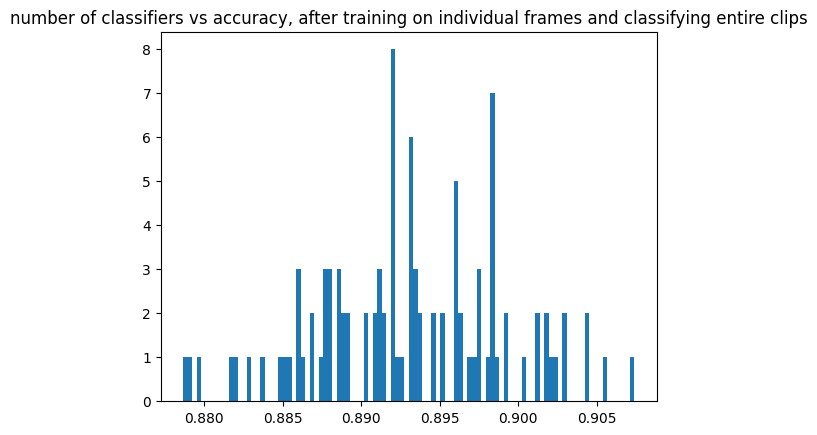

<Figure size 640x480 with 0 Axes>

In [8]:
plt.hist(accuracies,bins=100)
plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
plt.figure()

### Conclusions of Frame by Frame classifier

---
The frame by frame classifier seems to do pretty well on random frames. We can now try to extend this concept to classifying on each clip. 

---


## Clip by Clip Classifier

---

1. Import the concatenated vector data so that we have an entire clip as a row

In [31]:
data_C = pd.read_csv("data_concat.csv",header=None)
data_C = data_C.sample(frac=1)
data_C = data_C.reset_index(drop=True)
labels_C = data_C[0]
data_C = data_C.drop(0,axis='columns')
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
X_train_C = X_train_C.to_numpy()
X_test_C = X_test_C.to_numpy()
y_train_C = np.asarray(y_train_C.values.tolist())
y_train_C = y_train_C.reshape(-1,1)
y_test_C = np.asarray(y_test_C.values.tolist())
y_test_C = y_test_C.reshape(-1,1)

In [32]:
print(pd.Series(labels_C).value_counts())
print(pd.Series(y_train_C.ravel()).value_counts())
print(pd.Series(y_test_C.ravel()).value_counts())

0.0    74
1.0    73
Name: 0, dtype: int64
0.0    53
1.0    49
dtype: int64
1.0    24
0.0    21
dtype: int64


In [33]:
print("NONCONCAT DATA SHAPES")
# print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print("CONCAT DATA SHAPES")
# print(data_C.shape)
print(X_train_C.shape)
print(X_test_C.shape)
print(y_train_C.shape)
print(y_test_C.shape)

NONCONCAT DATA SHAPES
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)
CONCAT DATA SHAPES
(102, 2040)
(45, 2040)
(102, 1)
(45, 1)


2. Reshape to extract frame-by-frame 

In [34]:
newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

print("CONCAT DATA SHAPES AFTER RESHAPING")
print(X_train_Cr.shape)
print(X_test_Cr.shape)


CONCAT DATA SHAPES AFTER RESHAPING
(6120, 34)
(2700, 34)


3. Stretch the y-labels of training and test set to fit the reshaped arrays

In [35]:
print("LABEL SHAPES BEFORE STRETCHING")
print(y_train_C.shape)
print(y_test_C.shape)

y_train_Cr = np.copy(y_train_C)
y_test_Cr = np.copy(y_test_C)

y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
y_train_Cr = np.reshape(y_train_Cr,(-1,1))
y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
y_test_Cr = np.reshape(y_test_Cr,(-1,1))

print("LABEL SHAPES AFTER STRETCHING")
print(y_train_Cr.shape)
print(y_test_Cr.shape)

LABEL SHAPES BEFORE STRETCHING
(102, 1)
(45, 1)
LABEL SHAPES AFTER STRETCHING
(6120, 1)
(2700, 1)


In [36]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier()
cbm.fit(X_train_Cr,y_train_Cr)

Learning rate set to 0.022329
0:	learn: 0.6887276	total: 9.14ms	remaining: 9.13s
1:	learn: 0.6832753	total: 16.8ms	remaining: 8.4s
2:	learn: 0.6788040	total: 26ms	remaining: 8.64s
3:	learn: 0.6739188	total: 36.5ms	remaining: 9.08s
4:	learn: 0.6694668	total: 44.5ms	remaining: 8.86s
5:	learn: 0.6651620	total: 54.9ms	remaining: 9.1s
6:	learn: 0.6609493	total: 63ms	remaining: 8.94s
7:	learn: 0.6566066	total: 73.8ms	remaining: 9.15s
8:	learn: 0.6524493	total: 81.8ms	remaining: 9s
9:	learn: 0.6484842	total: 91.3ms	remaining: 9.04s
10:	learn: 0.6452866	total: 99.9ms	remaining: 8.98s
11:	learn: 0.6411157	total: 108ms	remaining: 8.9s
12:	learn: 0.6376896	total: 117ms	remaining: 8.91s
13:	learn: 0.6343205	total: 125ms	remaining: 8.82s
14:	learn: 0.6309902	total: 132ms	remaining: 8.66s
15:	learn: 0.6276248	total: 141ms	remaining: 8.7s
16:	learn: 0.6251999	total: 152ms	remaining: 8.78s
17:	learn: 0.6225583	total: 162ms	remaining: 8.84s
18:	learn: 0.6198524	total: 173ms	remaining: 8.95s
19:	learn: 

4) Check the frame by frame accuracy of the fit classifier

CATBOOST REV 2 STATS:
ACCURACY: 0.6255555555555555
ROC AUC: 0.6803108465608466


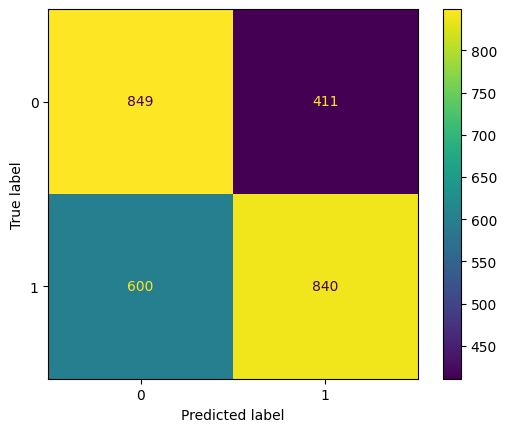

In [37]:
displayStats(cbm, "CATBOOST REV 2", X_test_Cr, y_test_Cr)

The frame by frame accuracy is worse, due to the less shuffled nature of the training dataset (we're shuffling in 60-frame chunks, instead of single frame shuffling)

Let's attempt to use this classifier to vote on clips, but if this does not work well, we may need to explore alternative strategies.

5) Classify 60 frames at a time (one clip) and take a majority consensus to classify a clip.

In [38]:
preds = []
softpreds = []
for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
    clip = np.reshape(clip,(1,-1))
    numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
    numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
    clip = np.reshape(clip,(numrows, numcols))
    
    #classify each row in clip
    clipPreds = cbm.predict(clip)
    clipSoftPreds = cbm.predict_proba(clip)[:,1]
    softprediction = np.average(clipSoftPreds)
    
    prediction = np.sum(clipPreds)
    if(prediction < (clipPreds.shape[0]/2)):
        prediction = 0
    else:
        prediction = 1
    
    preds.append(prediction)
    softpreds.append(softprediction)
preds = np.asarray(preds)
softpreds = np.asarray(softpreds)

ACCURACY: 0.6666666666666666
ROC AUC: 0.7162698412698413


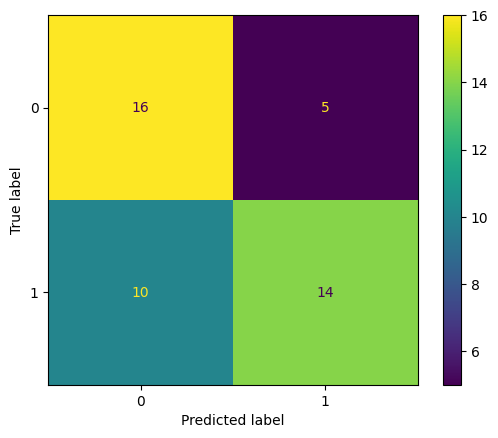

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

preds = np.reshape(preds,(-1,1))
print("ACCURACY: "+str(accuracy_score(y_test_C,preds)))
print("ROC AUC: "+str(roc_auc_score(y_test_C,softpreds)))

cmat = confusion_matrix(y_test_C,preds)
disp = ConfusionMatrixDisplay(cmat)
disp.plot()
plt.show()

The accuracy does not drop off significantly compared to classifying individual frames in the random frame classification. One possible hyperparameter that we can tune to improve it is the bias when computing the voted score. Currently, bad frames and good frames contribute equally to the clip's prediction. However, we can adjust this to bias more towards good frames, or more towards bad frames, and see if we can boost the accuracy. 

First however, we need to generate a histogram to look at accuracy across multiple runs.

## Sanity Check
Generating histogram for clip classifier

---

In [40]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as pyplot

accuracies = []
roc_aucs = []

for i in range(100):
    #get the data
    data_C = pd.read_csv("data_concat.csv",header=None)
    data_C = data_C.sample(frac=1)
    data_C = data_C.reset_index(drop=True)
    labels_C = data_C[0]
    data_C = data_C.drop(0,axis='columns')
    X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
    X_train_C = X_train_C.to_numpy()
    X_test_C = X_test_C.to_numpy()
    y_train_C = np.asarray(y_train_C.values.tolist())
    y_train_C = y_train_C.reshape(-1,1)
    y_test_C = np.asarray(y_test_C.values.tolist())
    y_test_C = y_test_C.reshape(-1,1)

    #transform
    newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
    X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

    newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
    X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

    y_train_Cr = np.copy(y_train_C)
    y_test_Cr = np.copy(y_test_C)

    y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
    y_train_Cr = np.reshape(y_train_Cr,(-1,1))
    y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
    y_test_Cr = np.reshape(y_test_Cr,(-1,1))

    # fit classifier
    cbm = CatBoostClassifier(silent=True)
    cbm.fit(X_train_Cr,y_train_Cr)
    preds = []
    softpreds = []
    for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
        clip = np.reshape(clip,(1,-1))
        numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
        numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
        clip = np.reshape(clip,(numrows, numcols))
        
        #classify each row in clip
        clipPreds = cbm.predict(clip)
        clipSoftPreds = cbm.predict_proba(clip)[:,1]
        softprediction = np.average(clipSoftPreds)
        
        prediction = np.sum(clipPreds)
        if(prediction < (clipPreds.shape[0]/2)):
            prediction = 0
        else:
            prediction = 1
        
        preds.append(prediction)
        softpreds.append(softprediction)
    preds = np.asarray(preds)
    softpreds = np.asarray(softpreds)
    preds = np.reshape(preds,(-1,1))
    
    accuracies.append(accuracy_score(y_test_C,preds))
    roc_aucs.append(roc_auc_score(y_test_C,softpreds))

<Figure size 640x480 with 0 Axes>

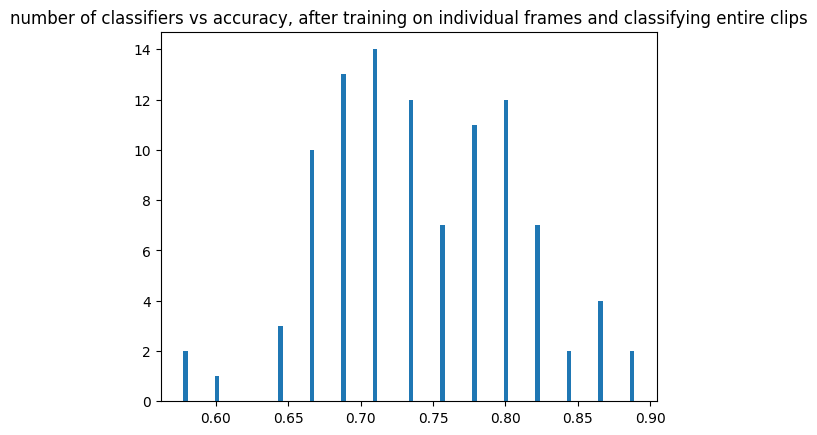

<Figure size 640x480 with 0 Axes>

In [41]:
plt.hist(accuracies,bins=100)
plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
plt.figure()

In [42]:
accuracies = np.asarray(accuracies)
print("STD Deviation of accuracy: "+str(np.std(accuracies)))
print("mean of accuracy: "+str(np.mean(accuracies)))

STD Deviation of accuracy: 0.06613827639830261
mean of accuracy: 0.7420000000000002


In [43]:
roc_aucs = np.asarray(roc_aucs)
print("STD Deviation of ROC-AUC: "+str(np.std(roc_aucs)))
print("mean of ROC-AUC: "+str(np.mean(roc_aucs)))

STD Deviation of ROC-AUC: 0.059136251952945175
mean of ROC-AUC: 0.7971626965307732


## Bias parameter tuning

Tuning the proportion of good/bad frames to classify a clip

---

STD Deviation of accuracy: 0.05943727890353654
mean of accuracy: 0.6846666666666665
STD Deviation of ROC-AUC: 0.061299761394983505
mean of ROC-AUC: 0.7911204588338895
STD Deviation of accuracy: 0.05488978856662584
mean of accuracy: 0.7406666666666668
STD Deviation of ROC-AUC: 0.056655460865947596
mean of ROC-AUC: 0.8071307722301967
STD Deviation of accuracy: 0.07107638040764212
mean of accuracy: 0.6822222222222224
STD Deviation of ROC-AUC: 0.05209417967838732
mean of ROC-AUC: 0.7993550128880468


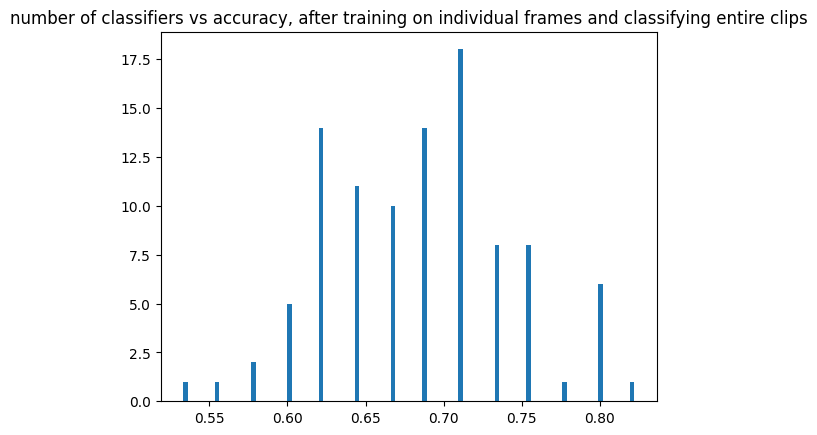

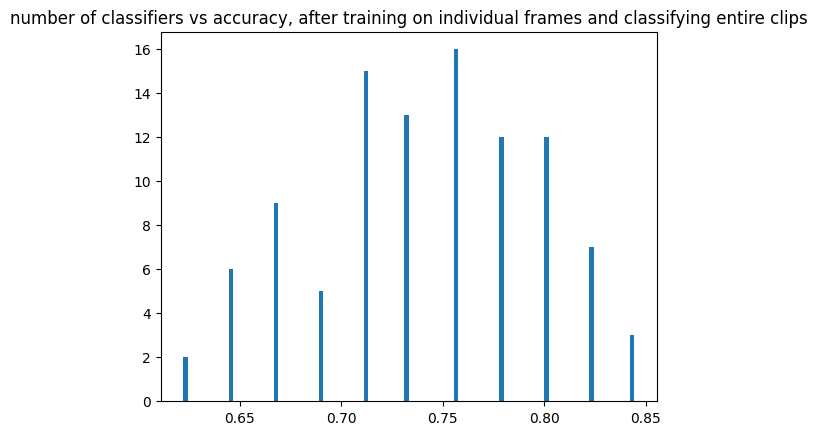

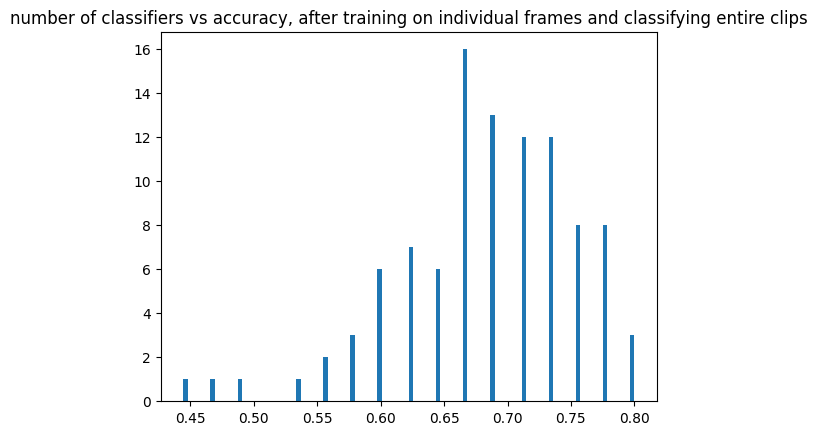

<Figure size 640x480 with 0 Axes>

In [44]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from matplotlib import pyplot as pyplot

for bias in [1/4,1/2,3/4]:
    accuracies = []
    roc_aucs = []

    for i in range(100):
        #get the data
        data_C = pd.read_csv("data_concat.csv",header=None)
        data_C = data_C.sample(frac=1)
        data_C = data_C.reset_index(drop=True)
        labels_C = data_C[0]
        data_C = data_C.drop(0,axis='columns')
        X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
        X_train_C = X_train_C.to_numpy()
        X_test_C = X_test_C.to_numpy()
        y_train_C = np.asarray(y_train_C.values.tolist())
        y_train_C = y_train_C.reshape(-1,1)
        y_test_C = np.asarray(y_test_C.values.tolist())
        y_test_C = y_test_C.reshape(-1,1)

        #transform
        newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
        X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

        newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
        X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

        y_train_Cr = np.copy(y_train_C)
        y_test_Cr = np.copy(y_test_C)

        y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
        y_train_Cr = np.reshape(y_train_Cr,(-1,1))
        y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
        y_test_Cr = np.reshape(y_test_Cr,(-1,1))

        # fit classifier
        cbm = CatBoostClassifier(silent=True)
        cbm.fit(X_train_Cr,y_train_Cr)
        preds = []
        softpreds = []
        for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
            clip = np.reshape(clip,(1,-1))
            numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
            numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
            clip = np.reshape(clip,(numrows, numcols))
            
            #classify each row in clip
            clipPreds = cbm.predict(clip)
            clipSoftPreds = cbm.predict_proba(clip)[:,1]
            softprediction = np.average(clipSoftPreds)
            
            prediction = np.sum(clipPreds)
            if(prediction < int(clipPreds.shape[0]*bias)): 
                prediction = 0
            else:
                prediction = 1
            
            preds.append(prediction)
            softpreds.append(softprediction)
        preds = np.asarray(preds)
        softpreds = np.asarray(softpreds)
        preds = np.reshape(preds,(-1,1))
        
        accuracies.append(accuracy_score(y_test_C,preds))
        roc_aucs.append(roc_auc_score(y_test_C,softpreds))

    plt.hist(accuracies,bins=100)
    plt.title("number of classifiers vs accuracy, after training on individual frames and classifying entire clips")
    plt.figure()
    accuracies = np.asarray(accuracies)
    print("STD Deviation of accuracy: "+str(np.std(accuracies)))
    print("mean of accuracy: "+str(np.mean(accuracies)))
    roc_aucs = np.asarray(roc_aucs)
    print("STD Deviation of ROC-AUC: "+str(np.std(roc_aucs)))
    print("mean of ROC-AUC: "+str(np.mean(roc_aucs)))

The bias parameter that has the best accuracy also does not differ greatly from the others in ROC-AUC. As such, I believe that having 1/2 as the bias parameter (good and bad frames equally weighted) is the best, so that we get a good result on both metrics. If ROC-AUC is the only metric that we want to consider, then a bias of 3/4ths performs better.

### Conclusion of Clip Classifier using frame classification

---

We can see that the accuracy has improved over the raw clip classification, and that the standard deviation of that accuracy itself has gone down. This makes sense, as the classifier has much more data to train on, and can better. By classifying the frames of each clip and taking a majority vote of good frames vs bad frames, it also softens the impact of minor deviations, whereas if classifying the entire clip all at once, it is possible that a deviation at a certain point in the shot affects the classification very strongly. This approach classes deviations equally, and doesn't let one bad frame outweigh multiple good frames.

The downside of this approach is that it completely disregards the temporal relationship between the frames themselves. If there is a good shot, and it's frames were scrambled, it would not actually be visually representative of a good basketball free throw. However, this classifier will still likely identify it as a good shot. 

A solution to this downside is potentially designing a multi-class frame-by-frame classifier, where each frame in a good clip is labeled 1,2,3,...,60, and each frame in a bad clip is labeled -1,-2,-3,...,-60. This would allow for greater differentiation, but the clip voting process would become more complex, as we could no longer simply take a majority vote. We would likely have to take both a majority vote, and consider the sequence of the labeled frames in the clip. 

A possible metric that we could use is least squared distance between sequential labels. The more sequentially ordered the label vector is, the smaller this number will be. It is highly likely that good shots will be well-ordered, and similar, due to us only profiling free throws. As such, using a sequentiality metric could perform well. We could also combine this with the average value of the sign function across the label vector, which is what we already do in the above model to determine a good/bad shot.

Another idea is potentially training multiple classifiers on subsections of the data. There is a good chance that a good frame for frame 1 is the same as a bad frame for frame 15. Therefore, if we split a 60-frame clip into 4 15-frame clips, and classify each of those individually and vote on those, we may end up with an improved result. This could be architected as a 2-level version of the model is presented in this notebook, simply with additional data slicing and more underlying estimators.